# **ANALISADOR DE SENTIMENTOS COM OBJETIVO DE ANALISAR COMO ESTÁ A RELAÇÃO TORCEDOR E CLUBE**

In [ ]:
!pip install transformers
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertForSequenceClassification, AdamW

## CAMINHO PARA O DRIVE

In [ ]:
positive_tweets_file = "/content/drive/MyDrive/Tweets/Positivo.txt"
negative_tweets_file = "/content/drive/MyDrive/Tweets/Negativo.txt"

def read_tweets_from_file(file_path, label):
    with open(file_path, "r", encoding="utf-8") as file:
        tweets = file.readlines()
    tweets = [tweet.strip() for tweet in tweets]
    df = pd.DataFrame({"tweet": tweets, "label": label})
    return df

positive_df = read_tweets_from_file(positive_tweets_file, 1)
negative_df = read_tweets_from_file(negative_tweets_file, 0)

df = pd.concat([positive_df, negative_df], ignore_index=True)

## REPARTINDO O DATASET

In [ ]:
train_df, temp_df = train_test_split(df, test_size=0.3, stratify=df["label"], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df["label"], random_state=42)

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, data, tokenizer, max_length):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        tweet = str(self.data.iloc[idx]["tweet"])
        label = self.data.iloc[idx]["label"]

        encoding = self.tokenizer.encode_plus(
            tweet,
            add_special_tokens=True,
            max_length=self.max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )

        return {
            "input_ids": encoding["input_ids"].flatten(),
            "attention_mask": encoding["attention_mask"].flatten(),
            "label": torch.tensor(label, dtype=torch.long)
        }

In [ ]:
tokenizer = BertTokenizer.from_pretrained("neuralmind/bert-base-portuguese-cased")
max_length = 128
batch_size = 16

In [ ]:
train_dataset = CustomDataset(train_df, tokenizer, max_length)
val_dataset = CustomDataset(val_df, tokenizer, max_length)
test_dataset = CustomDataset(test_df, tokenizer, max_length)

In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## IMPORTANDO O MODELO E REALIZANDO O FINETUNNING

In [ ]:
model = BertForSequenceClassification.from_pretrained("neuralmind/bert-base-portuguese-cased", num_labels=2)

Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the

In [ ]:
learning_rate = 2e-5
epochs = 20

optimizer = AdamW(model.parameters(), lr=learning_rate)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
def train(model, train_dataloader, val_dataloader, optimizer, epochs):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    criterion = torch.nn.CrossEntropyLoss()
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        val_loss = 0.0

        for batch in train_dataloader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)

            optimizer.zero_grad()

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)

            loss = outputs.loss
            logits = outputs.logits

            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        train_loss /= len(train_dataloader)
        train_losses.append(train_loss)

        model.eval()

        with torch.no_grad():
            for batch in val_dataloader:
                input_ids = batch["input_ids"].to(device)
                attention_mask = batch["attention_mask"].to(device)
                labels = batch["label"].to(device)

                outputs = model(input_ids, attention_mask=attention_mask, labels=labels)

                loss = outputs.loss

                val_loss += loss.item()

            val_loss /= len(val_dataloader)
            val_losses.append(val_loss)

        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f} - Val Loss: {val_loss:.4f}")

    return train_losses, val_losses

Epoch 1/20 - Train Loss: 0.6907 - Val Loss: 0.6804
Epoch 2/20 - Train Loss: 0.6362 - Val Loss: 0.6116
Epoch 3/20 - Train Loss: 0.5566 - Val Loss: 0.5233
Epoch 4/20 - Train Loss: 0.3681 - Val Loss: 0.3935
Epoch 5/20 - Train Loss: 0.1912 - Val Loss: 0.3383
Epoch 6/20 - Train Loss: 0.0677 - Val Loss: 0.3915
Epoch 7/20 - Train Loss: 0.0246 - Val Loss: 0.3609
Epoch 8/20 - Train Loss: 0.0165 - Val Loss: 0.3934
Epoch 9/20 - Train Loss: 0.0091 - Val Loss: 0.4471
Epoch 10/20 - Train Loss: 0.0064 - Val Loss: 0.5364
Epoch 11/20 - Train Loss: 0.0054 - Val Loss: 0.5998
Epoch 12/20 - Train Loss: 0.0049 - Val Loss: 0.5877
Epoch 13/20 - Train Loss: 0.0040 - Val Loss: 0.4542
Epoch 14/20 - Train Loss: 0.0033 - Val Loss: 0.3772
Epoch 15/20 - Train Loss: 0.0029 - Val Loss: 0.3810
Epoch 16/20 - Train Loss: 0.0026 - Val Loss: 0.3859
Epoch 17/20 - Train Loss: 0.0025 - Val Loss: 0.3898
Epoch 18/20 - Train Loss: 0.0022 - Val Loss: 0.3953
Epoch 19/20 - Train Loss: 0.0021 - Val Loss: 0.4017
Epoch 20/20 - Train L

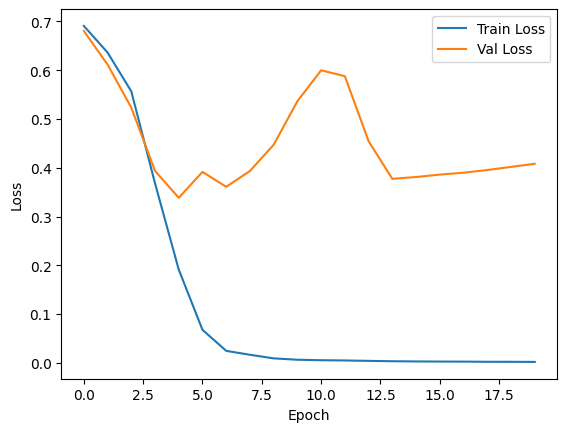

In [ ]:
train_losses, val_losses = train(model, train_dataloader, val_dataloader, optimizer, epochs)

import matplotlib.pyplot as plt

plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

## TESTANDO O MODELO

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

model.eval()

true_labels = []
predicted_labels = []

with torch.no_grad():
    for batch in test_dataloader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        _, predicted = torch.max(logits, dim=1)

        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

In [ ]:
confusion = confusion_matrix(true_labels, predicted_labels)

In [ ]:
target_names = ["Negativo", "Positivo"]
classification_rep = classification_report(true_labels, predicted_labels, target_names=target_names)
print(classification_rep)

              precision    recall  f1-score   support

    Negativo       0.88      0.88      0.88        16
    Positivo       0.89      0.89      0.89        18

    accuracy                           0.88        34
   macro avg       0.88      0.88      0.88        34
weighted avg       0.88      0.88      0.88        34



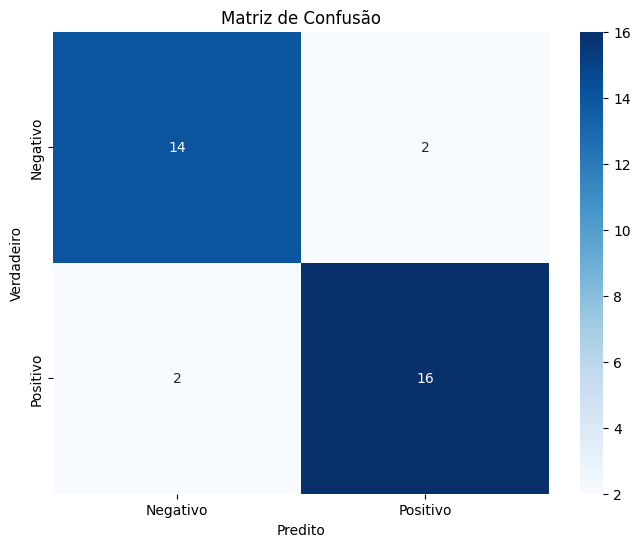

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", xticklabels=target_names, yticklabels=target_names)
plt.title("Matriz de Confusão")
plt.xlabel("Predito")
plt.ylabel("Verdadeiro")
plt.show()

## TESTANDO COM NOVOS INPUTS

In [ ]:
input_sentence = input("Digite uma sentença: ")

Digite uma sentença: FALA DELEEEEEEEEE, EU TE AMO MEU MENINO


In [ ]:
encoded_input = tokenizer.encode_plus(
    input_sentence,
    add_special_tokens=True,
    max_length=max_length,
    padding="max_length",
    truncation=True,
    return_tensors="pt"
)
input_ids = encoded_input["input_ids"]
attention_mask = encoded_input["attention_mask"]

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

model.eval()

with torch.no_grad():
    input_ids = input_ids.to(device)
    attention_mask = attention_mask.to(device)

    outputs = model(input_ids, attention_mask=attention_mask)
    logits = outputs.logits
    _, predicted_label = torch.max(logits, dim=1)

predicted_label = predicted_label.item()

In [ ]:
class_names = ["Negativo", "Positivo"]
predicted_class = class_names[predicted_label]
print("Predição:", predicted_class)

Predição: Positivo
